In [ ]:
#Memasukan Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#mengambil data dari drive
file_path = '/content/drive/MyDrive/Tugas Kuliah/Big Data Analys/Baru Data Penderita kelainan mata.xlsx'
data = pd.read_excel(file_path)

In [ ]:
#Menampilkan data yang akan diolah
print("Jumlah baris dan kolom:", data.shape)
print("Contoh data:")
display(data.head())

Jumlah baris dan kolom: (465, 10)
Contoh data:


,Unnamed: 0,Nama,Usia,Jenis Kelamin,Profesi,Alamat,Jenis Lensa,Lensa Minus,Lensa Plush,Lensa Cly
0,No,Maulinda,22,P,Mahasiswa,Semarang,Bluerock,"R-1,00 L-0,05",R+0 L+0,"R-0,50 L-0.50"
1,1,Bayu,18,L,Pelajar,Semarang,Bluecromic,"R-0,50 L-0,25",R+0 L+0,R-0 L-0
2,2,Setya,25,L,Mahasiswa,Semarang,Bliecromic,"R-0,25 L-0,75",R+0 L+0,R-0 L-0
3,3,Ibu Agus,35,P,Pekerja,Demak,Progresive,"R-1,75 L-1,00",R+0 L+0,"R-0,75 L-0,75"
4,4,Ria,28,P,Mahasiswa,Semarang,Bluecromic,"R-3,25 L-4,00",R+0 L+0,R-0 L-0


In [ ]:
#test datashet apakah ada data null
print("\nJumlah nilai null:")
print(data.isnull().sum())


Jumlah nilai null:
Unnamed: 0       0
Nama             0
Usia             0
Jenis Kelamin    0
Profesi          0
Alamat           0
Jenis Lensa      0
Lensa Minus      0
Lensa Plush      0
Lensa Cly        0
dtype: int64


In [ ]:
#Salin data dan drop baris yang memiliki NaN pada kolom penting
df = data.copy()
df = df.dropna(subset=['Usia', 'Jenis Kelamin', 'Lensa Minus', 'Alamat'])

In [ ]:
# Normalisasi teks kolom sebelum encoding
df['Jenis Kelamin'] = df['Jenis Kelamin'].astype(str).str.strip().str.upper()
df['Profesi'] = df['Profesi'].astype(str).str.strip().str.title()
df['Alamat'] = df['Alamat'].astype(str).str.strip()


In [ ]:
#Simpan versi asli Jenis Kelamin untuk analisis
df['Jenis Kelamin Asli'] = df['Jenis Kelamin']

In [ ]:
#Encode Jenis Kelamin untuk keperluan clustering (L=0, P=1)
df['Jenis Kelamin'] = df['Jenis Kelamin'].map({'L': 0, 'P': 1})

In [ ]:
# Encode Profesi ke numerik
df['Profesi Encoded'] = LabelEncoder().fit_transform(df['Profesi'])

In [ ]:
# Ekstrak nama kota dari kolom 'Alamat'
# Jika alamat berupa "Jl. Sudirman, Semarang", kita ambil bagian terakhir
def extract_kota(alamat):
    if isinstance(alamat, str):
        return alamat.split(',')[-1].strip().title()
    return np.nan

df['Kota'] = df['Alamat'].apply(extract_kota)


In [ ]:
# Encode Kota ke numerik
df['Kota Encoded'] = LabelEncoder().fit_transform(df['Kota'])

In [ ]:
def extract_avg_minus(value):
    value = str(value)
    matches = re.findall(r'R-?[\d,\.]+|L-?[\d,\.]+', value, flags=re.IGNORECASE)

    numbers = []
    for m in matches:
        num_str = re.findall(r'-?[\d,\.]+', m)[0].replace(',', '.')
        try:
            num = float(num_str)
            numbers.append(-abs(num))
        except:
            continue
    if numbers:
        return sum(numbers) / len(numbers)
    return None
df['Minus Rata-rata'] = df['Lensa Minus'].apply(extract_avg_minus)


## **Visualisasi Distribusi Mata Normal dan Tidak Normal**

In [ ]:
# Fungsi untuk cek apakah mata normal (Minus, Plush, Cly semuanya R-0 L-0 atau R+0 L+0)
def is_normal_eye(minus, plus, cly):
    def check_zero(value):
        if isinstance(value, str):
            value = value.replace(",", ".").replace(" ", "")
            return bool(re.match(r'R[-+]?0(?:\.0*)?L[-+]?0(?:\.0*)?$', value))
        return False
    return check_zero(minus) and check_zero(plus) and check_zero(cly)

In [ ]:
# Tambahkan kolom 'Mata Normal'
df['Mata Normal'] = df.apply(lambda row: is_normal_eye(row.get('Lensa Minus'), row.get('Lensa Plush'), row.get('Lensa Cly')), axis=1)

In [ ]:
# Hitung jumlah mata normal dan tidak normal
normal_counts = df['Mata Normal'].value_counts()
jumlah_normal = normal_counts.get(True, 0)
jumlah_tidak_normal = normal_counts.get(False, 0)

In [ ]:
# Tampilkan informasi jumlah
print(f"Jumlah penderita dengan mata normal     : {jumlah_normal}")
print(f"Jumlah penderita dengan mata tidak normal: {jumlah_tidak_normal}")

Jumlah penderita dengan mata normal     : 32
Jumlah penderita dengan mata tidak normal: 433


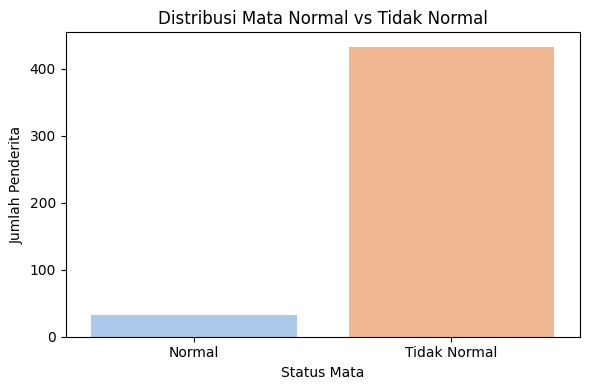

In [ ]:
# Buat DataFrame
data_status = pd.DataFrame({
    'Status Mata': ['Normal', 'Tidak Normal'],
    'Jumlah': [jumlah_normal, jumlah_tidak_normal]
})

# Visualisasi
plt.figure(figsize=(6, 4))
sns.barplot(data=data_status, x='Status Mata', y='Jumlah', hue='Status Mata', palette='pastel', legend=False)
plt.title("Distribusi Mata Normal vs Tidak Normal")
plt.xlabel("Status Mata")
plt.ylabel("Jumlah Penderita")
plt.tight_layout()
plt.show()

## **Visualisasi Distribusi Jumlah Penderita Berdasarkan Jenis Kelainan Mata**

In [ ]:
# Fungsi bantu untuk mendeteksi apakah kolom berisi nilai tidak nol
def has_problem(value, jenis='minus'):
    if isinstance(value, str):
        value = value.replace(",", ".").replace(" ", "").upper()
        # Regex untuk nilai bukan 0
        if jenis == 'minus' or jenis == 'cly':
            return not re.fullmatch(r'R-?0(?:\.0*)?L-?0(?:\.0*)?', value)
        elif jenis == 'plus':
            return not re.fullmatch(r'R\+?0(?:\.0*)?L\+?0(?:\.0*)?', value)
    return False

In [ ]:
# Tambahkan kolom status tiap jenis kelainan
df['Punya_Minus'] = df['Lensa Minus'].apply(lambda x: has_problem(x, 'minus'))
df['Punya_Plus'] = df['Lensa Plush'].apply(lambda x: has_problem(x, 'plus'))
df['Punya_Cly'] = df['Lensa Cly'].apply(lambda x: has_problem(x, 'cly'))


In [ ]:
# Hitung jumlah penderita per jenis kelainan
jumlah_minus = df['Punya_Minus'].sum()
jumlah_plus = df['Punya_Plus'].sum()
jumlah_cly = df['Punya_Cly'].sum()


In [ ]:
# Tampilkan jumlah
print(f"Jumlah penderita mata minus : {jumlah_minus}")
print(f"Jumlah penderita mata plus  : {jumlah_plus}")
print(f"Jumlah penderita silinder   : {jumlah_cly}")

Jumlah penderita mata minus : 347
Jumlah penderita mata plus  : 72
Jumlah penderita silinder   : 173


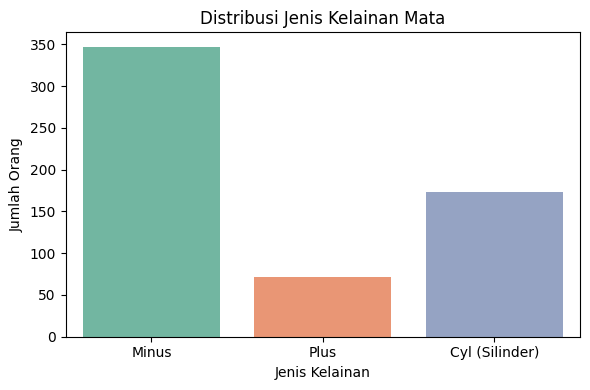

In [ ]:
# Buat DataFrame
data_kelainan = pd.DataFrame({
    'Jenis Kelainan': ['Minus', 'Plus', 'Cyl (Silinder)'],
    'Jumlah': [jumlah_minus, jumlah_plus, jumlah_cly]
})

# Visualisasi bar chart
plt.figure(figsize=(6, 4))
sns.barplot(data=data_kelainan, x='Jenis Kelainan', y='Jumlah', hue='Jenis Kelainan', palette='Set2', legend=False)
plt.title("Distribusi Jenis Kelainan Mata")
plt.ylabel("Jumlah Orang")
plt.xlabel("Jenis Kelainan")
plt.tight_layout()
plt.show()

## **Normalisasi Dataset**

In [ ]:
#Ambil data untuk clustering
df_cluster = df[['Usia', 'Jenis Kelamin', 'Minus Rata-rata', 'Kota Encoded',
                 'Profesi Encoded', 'Jenis Kelamin Asli', 'Kota', 'Profesi']].dropna()

In [ ]:
#Normalisasi fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[['Usia', 'Jenis Kelamin',
                                            'Minus Rata-rata', 'Kota Encoded',
                                            'Profesi Encoded']])

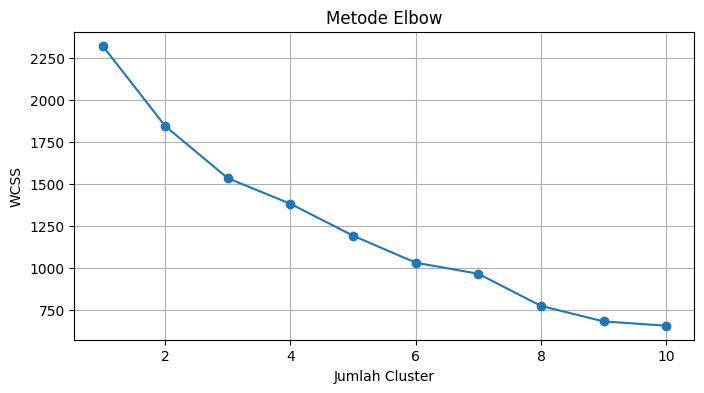

In [ ]:
#Metode Elbow untuk menentukan jumlah cluster optimal
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Metode Elbow')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [ ]:
#Clustering (misal k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
#PCA untuk visualisasi 2D
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df_cluster['PCA1'] = components[:, 0]
df_cluster['PCA2'] = components[:, 1]

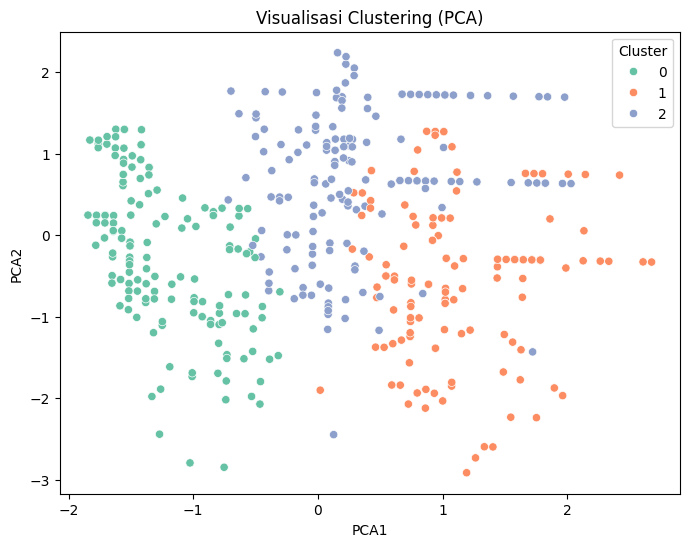

In [ ]:
#Visualisasi Clustering berdasarkan PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Visualisasi Clustering (PCA)')
plt.show()


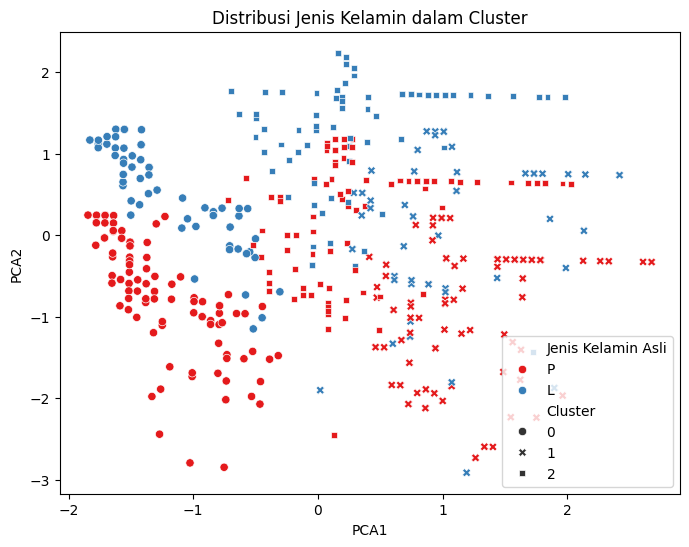

In [ ]:
#Visualisasi Distribusi Jenis Kelamin
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2',
hue='Jenis Kelamin Asli', style='Cluster', palette='Set1')
plt.title('Distribusi Jenis Kelamin dalam Cluster')
plt.show()

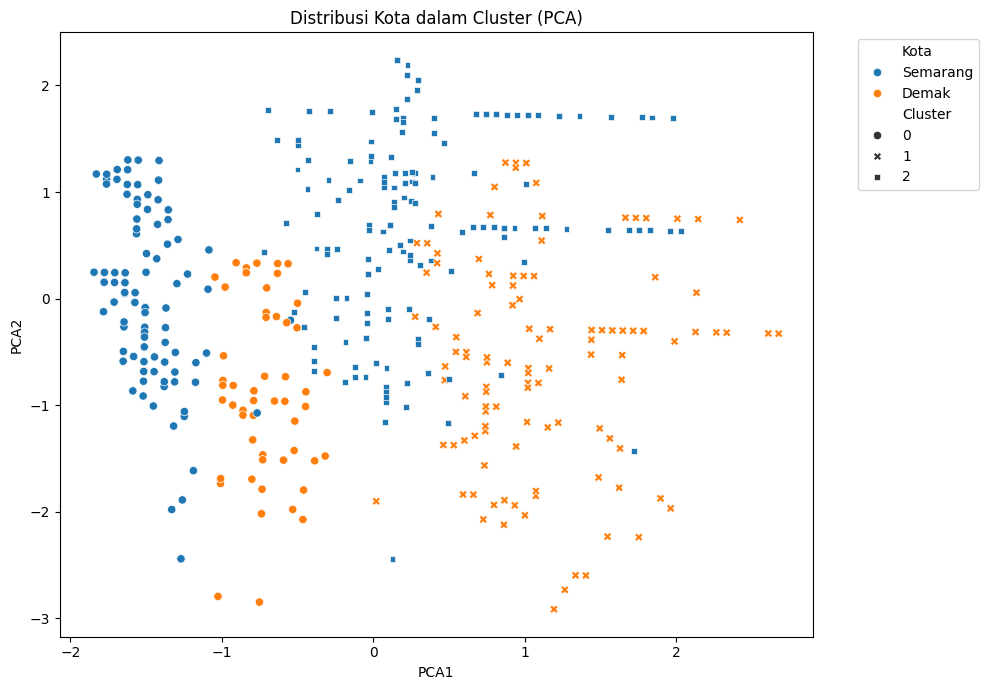

In [ ]:
#Visualisasi Distribusi Kota
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='Kota', style='Cluster', palette='tab10')
plt.title('Distribusi Kota dalam Cluster (PCA)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


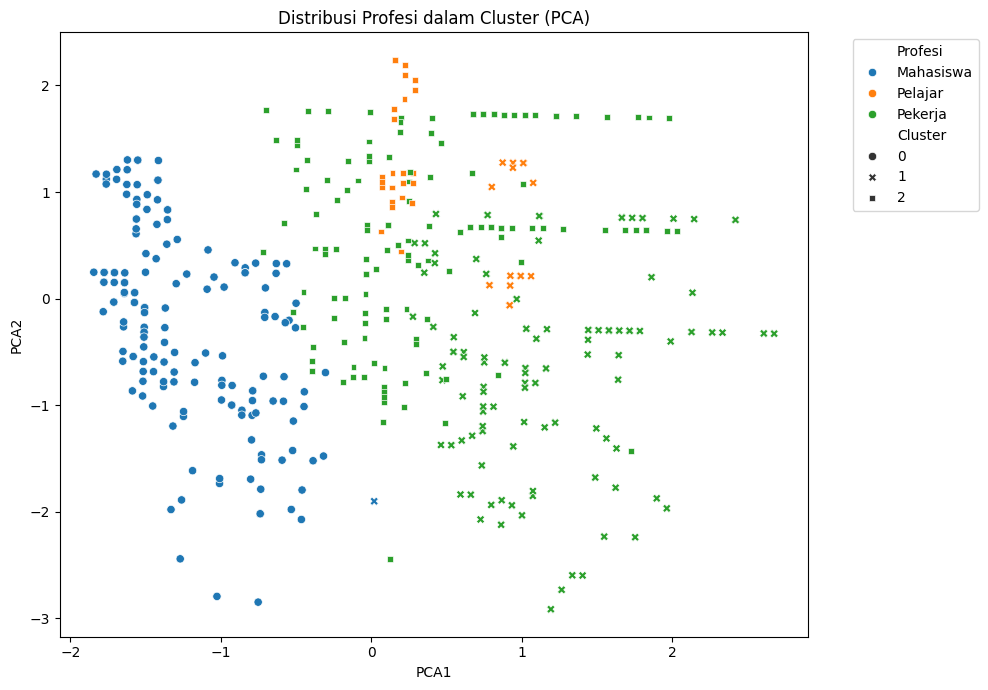

In [ ]:
# Visualisasi Distribusi Profesi
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='Profesi', style='Cluster', palette='tab10')
plt.title('Distribusi Profesi dalam Cluster (PCA)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
#Ringkasan per Cluster

print(" Rata-rata fitur per Cluster:")
print(df_cluster.groupby('Cluster')[['Usia', 'Minus Rata-rata']].mean())
print("\n")

print(" Distribusi Jenis Kelamin per Cluster:")
print(df_cluster.groupby(['Cluster', 'Jenis Kelamin Asli']).size().unstack(fill_value=0))
print("\n")

print(" Distribusi Kota per Cluster:")
print(df_cluster.groupby(['Cluster', 'Kota']).size().unstack(fill_value=0))
print("\n")

print(" Distribusi Profesi per Cluster:")
print(df_cluster.groupby(['Cluster', 'Profesi']).size().unstack(fill_value=0))


 Rata-rata fitur per Cluster:
              Usia  Minus Rata-rata
Cluster                            
0        24.065868        -1.529042
1        34.022901        -1.875763
2             33.0        -1.520331


 Distribusi Jenis Kelamin per Cluster:
Jenis Kelamin Asli   L    P
Cluster                    
0                   62  105
1                   48   83
2                   78   88


 Distribusi Kota per Cluster:
Kota     Demak  Semarang
Cluster                 
0           58       109
1          131         0
2            0       166


 Distribusi Profesi per Cluster:
Profesi  Mahasiswa  Pekerja  Pelajar
Cluster                             
0              167        0        0
1                1      115       15
2                0      141       25
